In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import lightgbm as lgbm
import xgboost as xgbm

In [3]:
df = pd.read_csv("diabetes2.csv")
print(df.shape)
print(df.info())
df.head()

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 1 EDA

In [4]:
# 1. Checking the missing/ duplicate values 
print(df.isnull().sum())
print(df.duplicated().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
0


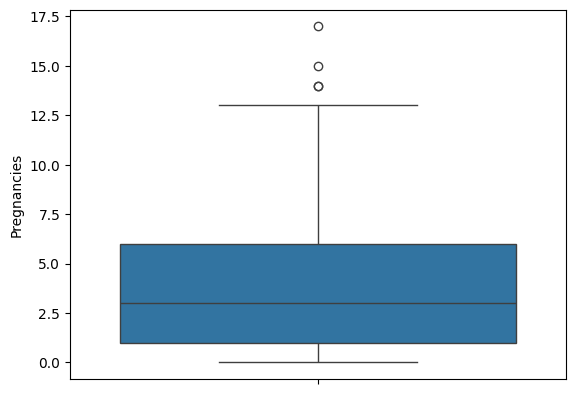

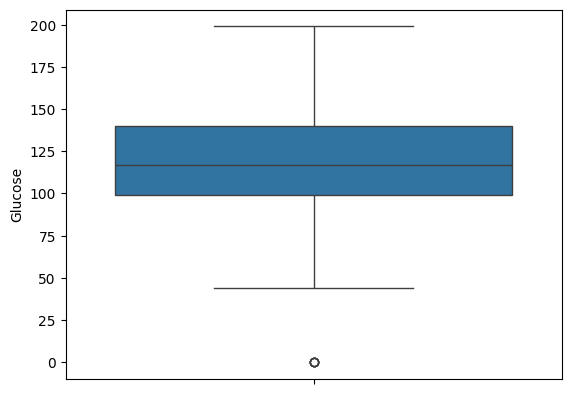

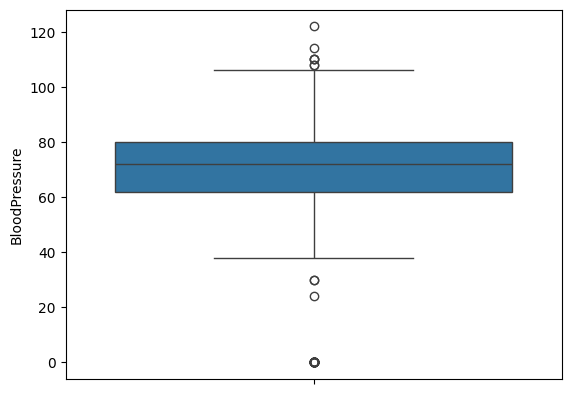

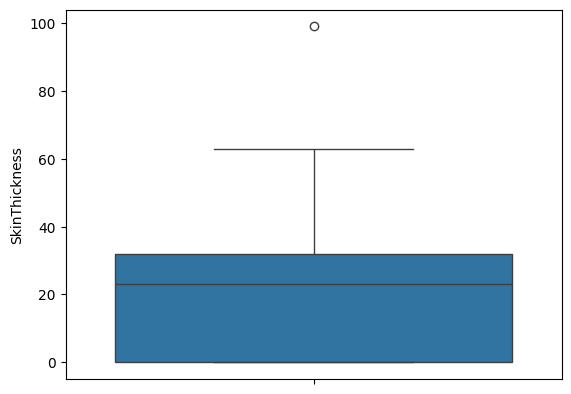

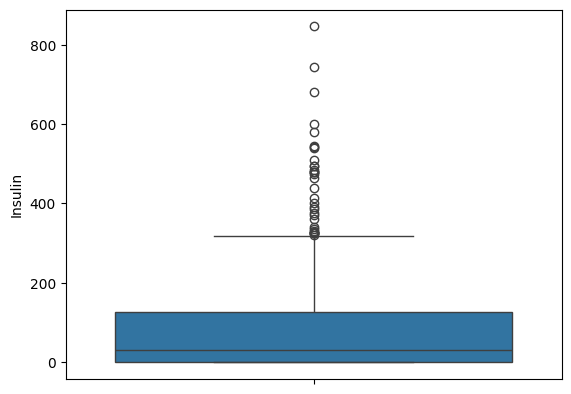

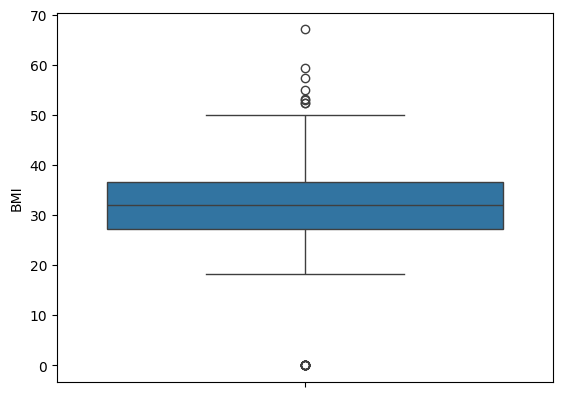

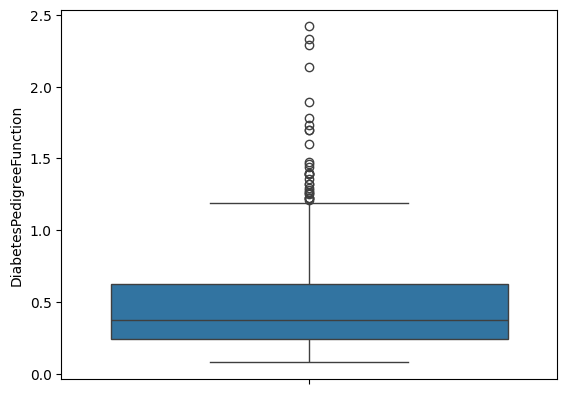

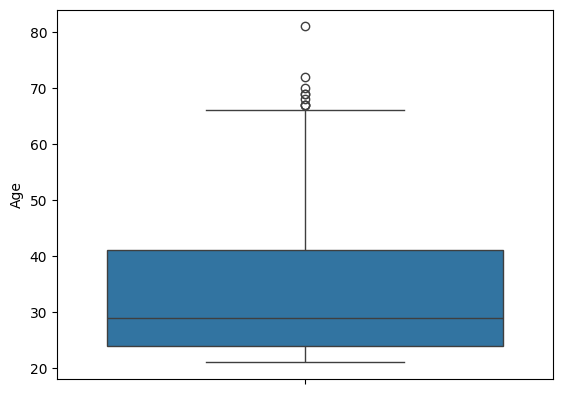

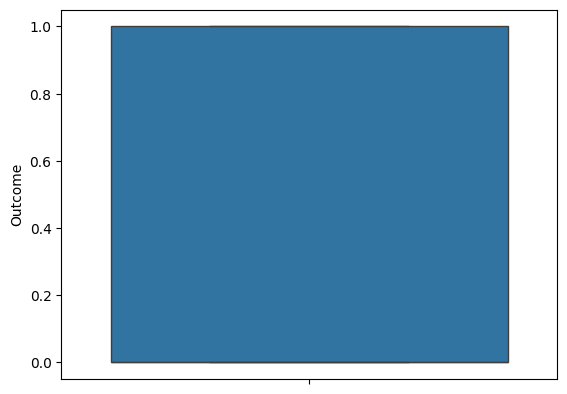

In [16]:
# 2. Visualization
for col in df.select_dtypes(["int", "float"]).columns:
    sns.boxplot(data =df, y=col)
    plt.show()

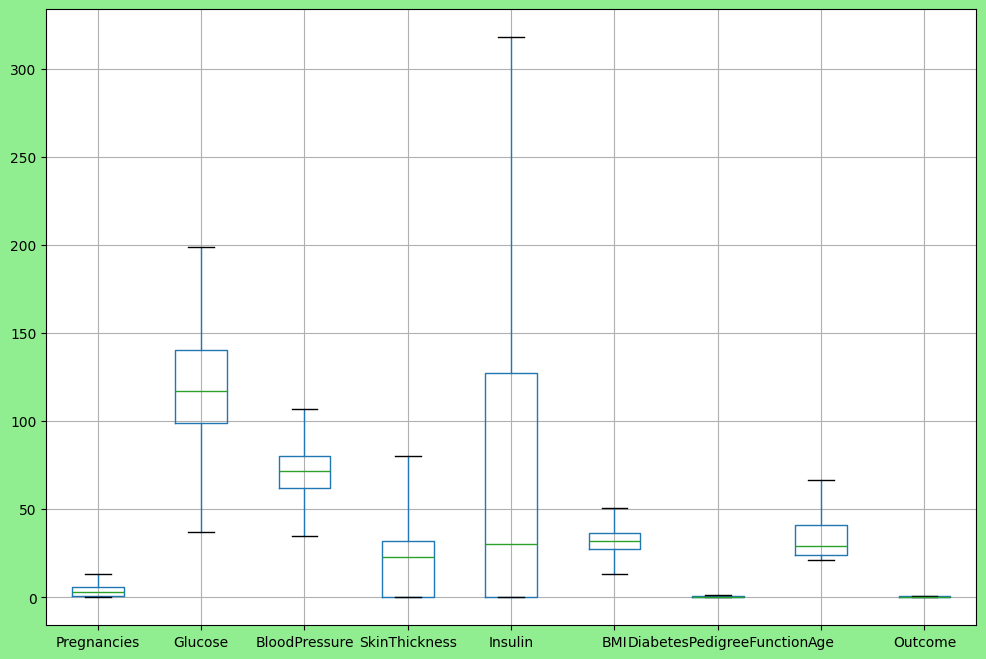

In [32]:
# Replacing Outliers

def replace_outliers(df):
    def replace(col):
        Q1 = df[col].quantile(0.25)        
        Q3 = df[col].quantile(0.75)     
        IQR = Q3 - Q1
        lower_extreme = Q1 - 1.5*IQR   
        upper_extreme = Q3 + 1.5*IQR   
        df[col] = df[col].apply(lambda x: lower_extreme if x < lower_extreme else upper_extreme if x > upper_extreme else x)

    for c in df.select_dtypes(include=["int", "float"]).columns:
        replace(c)

plt.figure(figsize=(12,8), facecolor="lightgreen")
replace_outliers(df)
df.boxplot()
plt.show()

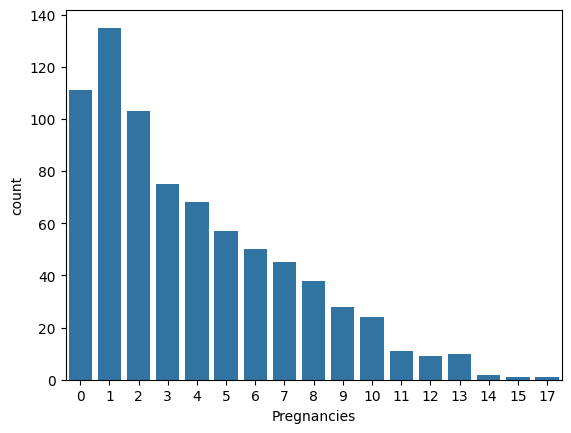

In [9]:
sns.countplot(data=df,x="Pregnancies")
plt.show()

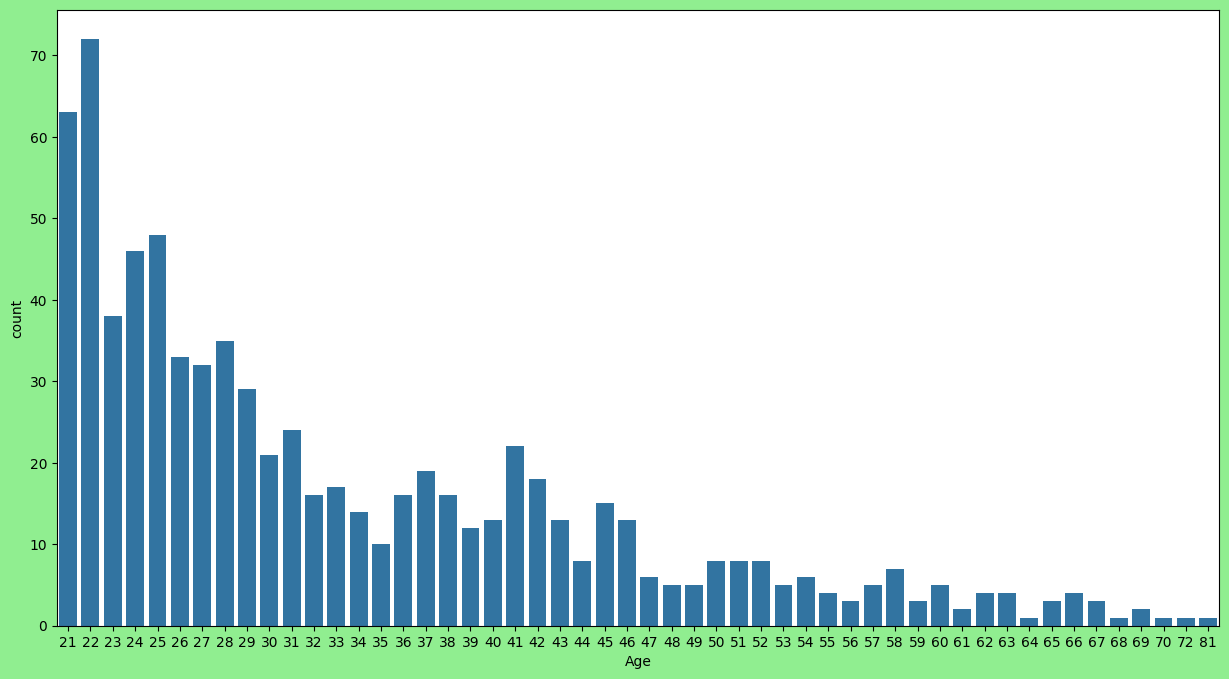

In [12]:
plt.figure(figsize=(15,8), facecolor="lightgreen")
sns.countplot(data=df,x="Age")
plt.show()

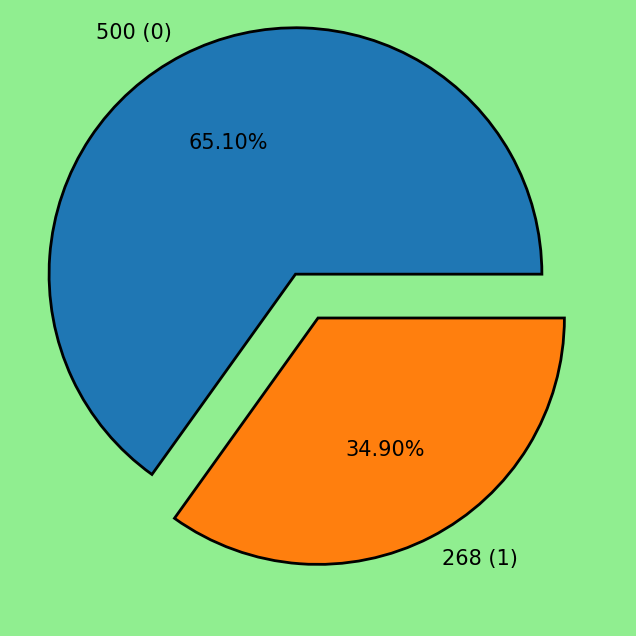

In [15]:
plt.figure(figsize=(12,8), facecolor="lightgreen")
data = df["Outcome"].value_counts()
labels = [f"{j} ({i})" for i,j in data.items()]
plt.pie(data, labels=labels, radius=1, autopct="%.2f%%", 
textprops={
    "color":"black",
    "size":15
},
wedgeprops={
    "linewidth":2,
    "edgecolor":"black"
},
explode=[0.2,0]
)
plt.show()

Text(0.5, 1.0, 'Experience vs Salary')

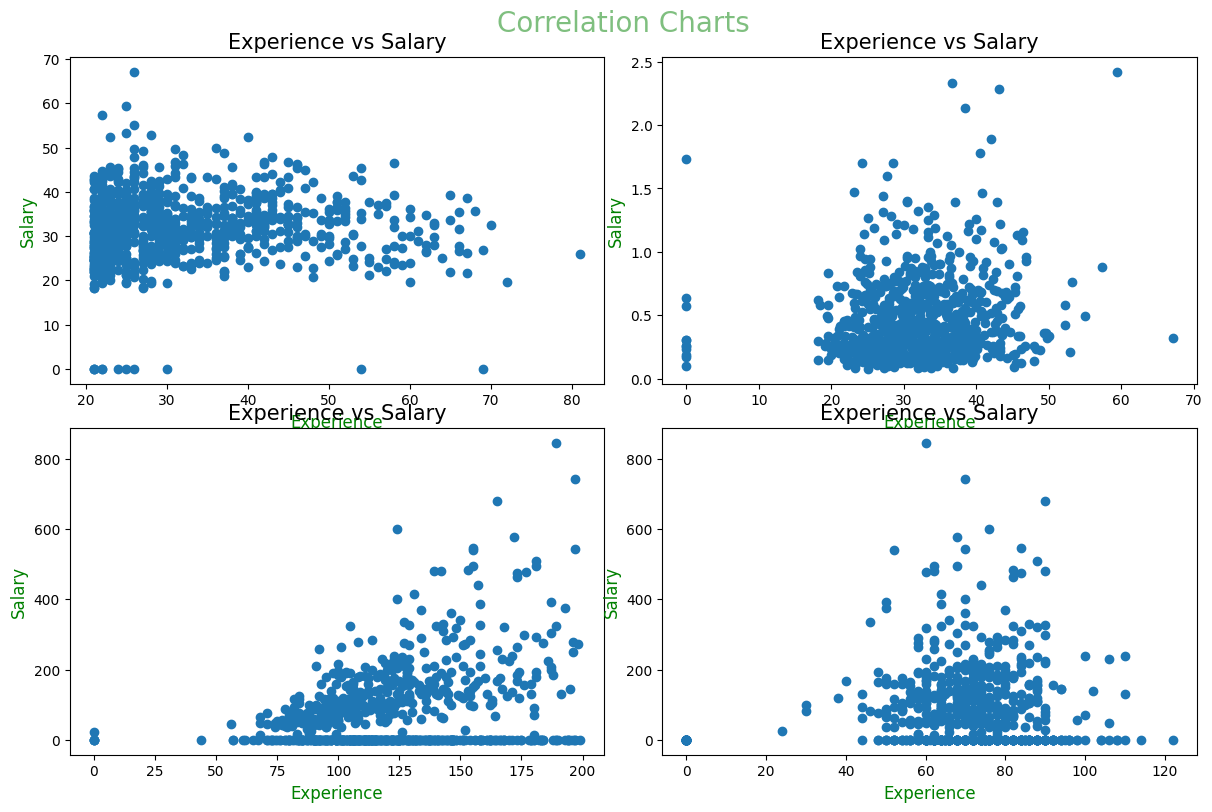

In [ ]:
# Subplot


fig, axs = plt.subplots(2,2,figsize=(12,8))
plt.suptitle("Correlation Charts", size=20, color="green", fontweight="light", alpha=0.5)
plt.tight_layout()

axs[0,0].scatter(df["Age"], df["BMI"])
axs[0,0].set_xlabel("Age", color="green", size=12)
axs[0,0].set_ylabel("BMI", color="green", size=12)
axs[0,0].set_title("Age vs BMI", color="black", size=15)

axs[0,1].scatter(df["BMI"], df["DiabetesPedigreeFunction"])
axs[0,1].set_xlabel("BMI", color="green", size=12)
axs[0,1].set_ylabel("DiabetesPedigreeFunction", color="green", size=12)
axs[0,1].set_title("BMI vs DiabetesPedigreeFunction", color="black", size=15)

axs[1,0].scatter(df["Glucose"], df["Insulin"])
axs[1,0].set_xlabel("Glucose", color="green", size=12)
axs[1,0].set_ylabel("Insulin", color="green", size=12)
axs[1,0].set_title("Glucose vs Insulin", color="black", size=15)

axs[1,1].scatter(df["BloodPressure"], df["Insulin"])
axs[1,1].set_xlabel("BloodPressure", color="green", size=12)
axs[1,1].set_ylabel("Insulin", color="green", size=12)
axs[1,1].set_title("BloodPressure vs Insulin", color="black", size=15)

# #. Model Building

In [ ]:
features = df.drop(columns=["Outcome"])
target = df["Outcome"]

In [42]:
# 1. Data Splitting
x_train, x_test, y_train, y_test = train_test_split(features, target)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(576, 8)
(576,)
(192, 8)
(192,)


In [43]:
# 1. XG Boosting

xg_boost = xgbm.XGBClassifier(n_estimators=100,learning_rate=0.1,min_child_weight=1,
                            subsample=0.9,max_features=1,reg_alpha=10,reg_lambda=10)

In [44]:
xg_boost.fit(x_train,y_train)
y_pred_xgbm = xg_boost.predict(x_test)
accuracy_score(y_test,y_pred_xgbm)

0.7291666666666666

In [45]:
# XG Boosting Grid search

params={'n_estimators':[50,100],'learning_rate':[0.1,0.5],'min_child_weight':[1,2,3]}
grid_search= GridSearchCV(estimator=xg_boost,param_grid=params, cv=5)
grid_search.fit(x_train,y_train)
grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.1, 'min_child_weight': 3, 'n_estimators': 50},
 np.float64(0.7830884557721138))

In [47]:
# 2. LG Boosting

lgbm = lgbm.LGBMClassifier(n_estimators=100,learning_rate=0.1,min_child_weight=1,
                            subsample=0.9,max_features=1,reg_alpha=10,reg_lambda=10,
                             max_bins=10,bundled=True,boosting_type='goss',top_rate=0.2,other_rate=0.3)

In [48]:
lgbm.fit(x_train,y_train)
y_pred_lgbm= lgbm.predict(x_test)
accuracy_score(y_test,y_pred_lgbm)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bundled
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bundled
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 198, number of negative: 378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the 

0.734375

In [ ]:
# LG Boosting Grid search

params={'n_estimators':[50,100],'learning_rate':[0.1,0.5],'min_child_weight':[1,2,3]}
grid_search= GridSearchCV(estimator=lgbm ,param_grid=params, cv=5)
grid_search.fit(x_train,y_train)
grid_search.best_params_, grid_search.best_score_

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bundled
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: bundled
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 158, number of negative: 302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the 

({'learning_rate': 0.5, 'min_child_weight': 1, 'n_estimators': 100},
 np.float64(0.7674362818590705))

In [ ]:
'''
| Model                 | Test Accuracy |
| --------------------- | ------------- |
| XGBoost (baseline)    |   72.9%       |
| XGBoost (GridSearch)  |   78.3%       |
| LightGBM (baseline)   |   73.4%       |
| LightGBM (GridSearch) |   76.7%       |

Key Observations
 - XGBoost with hyperparameter tuning achieved the best performance, indicating strong capability in handling non-linear relationships and feature interactions in medical data.
 - LightGBM also performed competitively, but did not surpass tuned XGBoost on this dataset.
 - Hyperparameter tuning significantly improved both models, highlighting the importance of model optimization.
 - The dataset is relatively small and structured, favoring XGBoost’s robust tree-splitting mechanisms.
 - LightGBM’s advanced techniques (GOSS, histogram binning) are more advantageous for large-scale datasets, which limits its edge here.

Practical Implications
 - For small to medium-sized healthcare datasets, XGBoost is a reliable choice due to its stability and superior accuracy after tuning.
 - LightGBM is suitable when training speed and scalability are priorities, especially with large datasets.
 - Proper preprocessing and hyperparameter tuning can yield substantial performance gains, sometimes more than switching algorithms.

Final Conclusion
 - XGBoost emerged as the better-performing model for diabetes prediction in this study, offering higher accuracy and robustness after tuning.
 - LightGBM remains a strong alternative, particularly for larger datasets, but did not outperform XGBoost in this scenario.
 '''